#**Projet - Régression logistique**

But : implémenter la régression logistique et mettre en oeuvre une méthodologie solide

Cours : M1 MIAGE apprentissage (Dauphine) - 2023-2024

Projet en binôme

A rendre :
*   Code ayant permis de résoudre les différentes questions (Notebook Python) - commenté pour permettre son exécution
*   Rapport en PDF (moins de 20 pages)

Date : le 01/12/2023 (avant 20h - heure de Paris)

In [71]:
# libairies utiles pour ce cours

# jeu de données
import sklearn as sk
from sklearn import datasets, model_selection

# calcul numériques (calculs d'estimateurs)
import numpy as np

#figures et illustrations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [72]:
#generation de données
n=100
rng = np.random.RandomState(2)
X,y = sk.datasets.make_classification(n_samples=n, n_features=2, n_redundant=0, n_informative=2, n_repeated=0, n_clusters_per_class=1, random_state=rng)

dim =2

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=.2, random_state=42)

# inclure cette ligne pour la question II.7
X_train[0,:] = [5,5]

Xb=np.column_stack((X_train,np.ones(X_train.shape[0])))
Xtb=np.column_stack((X_test,np.ones(X_test.shape[0])))

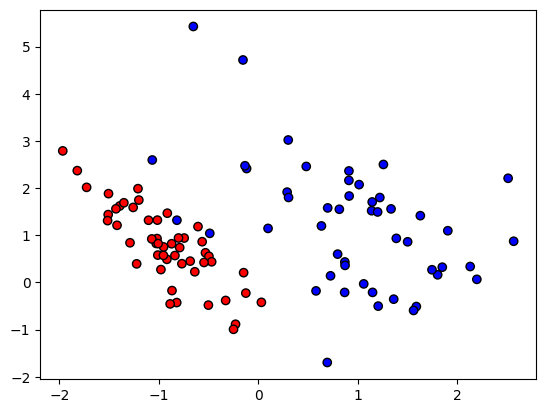

In [73]:
figure = plt.figure()
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,edgecolors='k')

## I Regression logistique (8pts)

1. En vous appuyant sur le code écrit pour le TP 2 (notamment la descente de gradient), implémenter la régression logistique (2pts)

  /!\ /!\  *il faudra modifier le code ou le problème d'optimisation car dans le TP2, on minimisait une fonction et là, on maximise une fonction* /!\ /!\
2. Calculer $\beta$, les paramètres de la frontière de décision (1 pt)
8. prédire la classe du point $x = \left( \begin{array}{c}
0 \\
0 \end{array} \right)$ (1 pt)
9. Représenter la frontière de décision (en ré-utilisant le code écrit pour le TP 1) (1pt)
10. Développer une fonction de calcul de taux d'erreur d'un modèle. Appliquer ce code pour estimer le taux d'erreur (en apprentissage et en test) de votre modèle de régression logistique. (1pt)
11. Comparer ces résultats (frontière de décisions et taux d'erreurs) à ceux obtenus sur ces données par votre code de LDA (développé pour le TP 1) - commenter (2 pts)

In [74]:
def sigmoid(beta, x):
    return 1/(1+np.exp(-np.dot(x,beta)))

Itération 1000, Négative Loss: 0.32974694631183726
Itération 2000, Négative Loss: 0.32974508142148673
decreasing loss
Paramètre finale : 
 [[ 2.19517083]
 [ 0.50475249]
 [-0.35578963]]


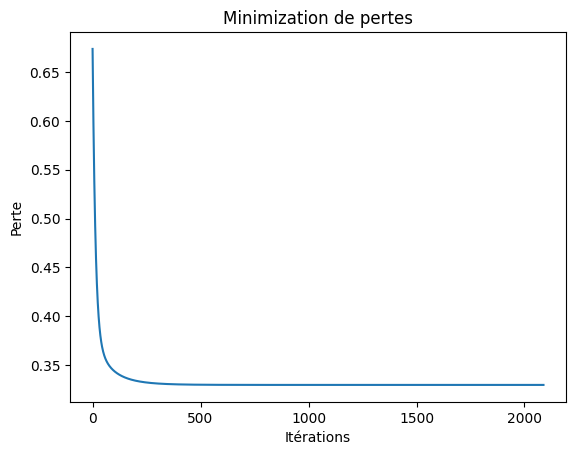

In [75]:
# descente de gradient
def gradient_descent(Xb, y_train, eta=1e-3, itermax=10000, epsilon=1e-8):
    dim = Xb.shape[1] - 1  # dimension de l'échantillon en enlevant la colonne de 1 (bias)
    beta = np.random.normal(size=(dim+1, 1))
    i = 1
    loss = []  # calcul de la fonction cout à chaque iteration
    loss_old = np.inf # ici -np.inf pour maximiser la fonction de perte, np.inf pour minimiser
    y_train = y_train.reshape(-1, 1)
    while(i <= itermax):
        beta_old = beta

        # Prédiction
        preds = sigmoid(beta, Xb)

        # Calcul du gradient
        # pour minization : 
        # grad = Xb.T @ (preds - y_train)
        grad = Xb.T @ (preds - y_train)

        # mise à jour le paramètre de l'hyperplan de l'itéré courant
        beta = beta_old - eta * grad # ajoute du gradient pour maximiser, soustrait pour minimiser

        # Calcul de la fonction de perte
        # pour minization : 
        # loss_new = - np.mean(y_train * np.log(preds) + (1 - y_train) * np.log(1 - preds))
        loss_new = - np.mean(y_train * np.log(preds) + (1 - y_train) * np.log(1 - preds))

        loss.append(loss_new)  # Append loss to the list

        # Critère de stabilité
        if np.linalg.norm(beta_old - beta) < epsilon: # inverse de minisization
            print("diff iterate")
            break

        # Critère de performance 
        if loss_new > loss_old: # inverse de minisization
            print("decreasing loss")
            break

        i += 1 
        loss_old = loss_new 

        if i % 1000 == 0:
            print(f"Itération {i}, Négative Loss: {loss_new}")
        
    return beta, loss

beta, loss = gradient_descent(Xb, y_train)
print("Paramètre finale : \n", beta)
plt.plot(loss)
plt.title("Minimization de pertes")
plt.xlabel("Itérations")
plt.ylabel("Perte")
plt.show()


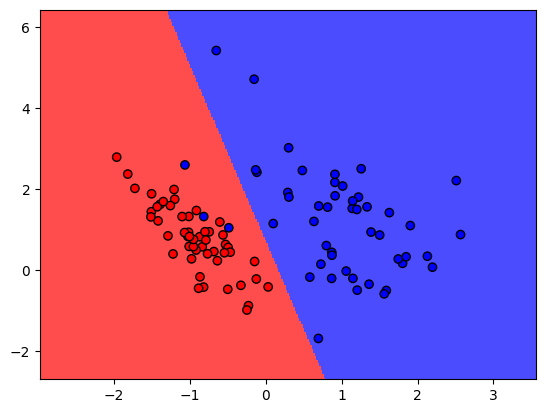

In [76]:
# frontière de décision
def decision_boundary(beta, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = .02

    xlim = np.arange(x_min, x_max, h)
    ylim = np.arange(y_min, y_max, h)

    xx, yy = np.meshgrid(xlim, ylim)

    # ajouter une colonne de 1 pour le biais
    Xtest = np.column_stack((xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])))
    ypred = sigmoid(beta, Xtest)
    ypred = ypred.reshape(xx.shape)

    figure = plt.figure()
    plt.pcolormesh(xx, yy, ypred, cmap=cm_bright, shading='auto', alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,edgecolors='k')

decision_boundary(beta, X, y)

In [77]:
# taux d'erreur
def error_rate(y,y_pred):
    return np.mean(y != y_pred.ravel())

In [78]:
class LinearDiscriminantAnalysis:
    def __init__(self):
        self.w = None
        self.b = None

    def fit(self, X, y):
        # Compute means
        mu_0 = np.mean(X[y == 0], axis=0)
        mu_1 = np.mean(X[y == 1], axis=0)

        # Compute class priors
        pi_0 = np.mean(y == 0)
        pi_1 = np.mean(y == 1)

        # Compute pooled covariance matrix
        Xtemp = np.concatenate((X[y == 0, :] - mu_0, X[y == 1, :] - mu_1), axis=0)
        Sigma = (Xtemp.T @ Xtemp) / len(Xtemp)

        # Compute inverse of Sigma
        iSigma = np.linalg.inv(Sigma)

        # Compute weights and bias
        self.w = iSigma @ (mu_0 - mu_1)
        self.b = -0.5 * np.dot(np.dot((mu_0 - mu_1).T, iSigma), (mu_0 + mu_1)) + np.log(pi_0 / pi_1)

    def predict(self, X):
        return 0.5 + 0.5 * np.sign(X @ self.w + self.b)

    def decision_boundary(self, X, y):
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])

        # Generating a grid of points
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        h = .02

        xlim = np.arange(x_min, x_max, h)
        ylim = np.arange(y_min, y_max, h)

        xx, yy = np.meshgrid(xlim, ylim)

        Xtest = np.column_stack((xx.ravel(), yy.ravel()))
        ypred = self.predict(Xtest)
        ypred = ypred.reshape(xx.shape)

        plt.figure()
        plt.pcolormesh(xx, yy, ypred, cmap=cm_bright, shading='auto', alpha=0.7)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
        plt.title("Frontière de décision LDA")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()
    
    def error_rate(self, y, y_pred):
        return np.mean(y != y_pred.ravel())

In [79]:
class LogisticRegression:
    def __init__(self, eta=1e-3, itermax=10000, epsilon=1e-10):
        self.eta = eta
        self.itermax = itermax
        self.epsilon = epsilon
        self.beta = None
        self.loss = []

    def sigmoid(self, X):
        return 1 / (1 + np.exp(-np.dot(X, self.beta)))

    def fit(self, X, y):
        Xb = np.column_stack((X, np.ones((X.shape[0], 1))))  # Add bias term
        dim = Xb.shape[1] - 1
        self.beta = np.random.normal(size=(dim+1, 1))
        y = y.reshape(-1, 1)
        loss_old = np.inf

        for i in range(1, self.itermax + 1):
            preds = self.sigmoid(Xb)
            grad = Xb.T @ (preds - y)
            beta_old = self.beta
            self.beta = beta_old - self.eta * grad
            loss_new = -np.mean(y * np.log(preds) + (1 - y) * np.log(1 - preds))
            self.loss.append(loss_new)

            if np.linalg.norm(beta_old - self.beta) < self.epsilon:
                print("Convergence achieved at iteration", i)
                break

            if loss_new > loss_old:
                print("Loss increasing at iteration", i)
                break

            loss_old = loss_new

    def predict_proba(self, X):
        Xb = np.column_stack((X, np.ones((X.shape[0], 1))))
        return self.sigmoid(Xb)

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba > 0.5).astype(int)

    def decision_boundary(self, X, y):
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        h = .02

        xlim = np.arange(x_min, x_max, h)
        ylim = np.arange(y_min, y_max, h)

        xx, yy = np.meshgrid(xlim, ylim)
        Xtest = np.column_stack((xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])))
        ypred = self.sigmoid(Xtest)
        ypred = ypred.reshape(xx.shape)

        plt.figure()
        plt.pcolormesh(xx, yy, ypred, cmap=cm_bright, shading='auto', alpha=0.7)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
        plt.title("Frontière de décision Régression Logistique")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()
        
    def error_rate(self, y, y_pred):
        return np.mean(y != y_pred.ravel())

Taux d'erreur LDA :  0.95


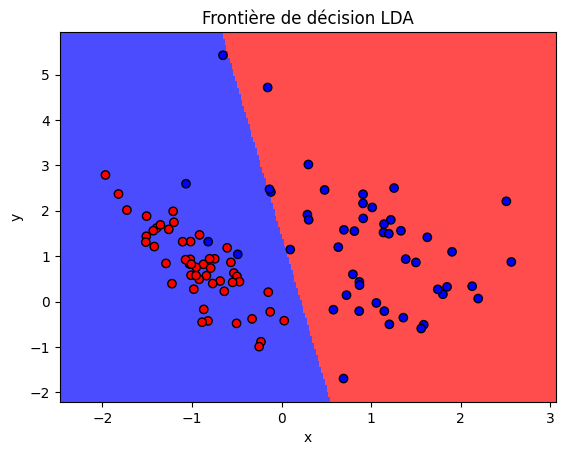

Loss increasing at iteration 2136
Taux d'erreur Logistic Regression :  0.05
Prédiction de la classe de x :  [[0]]


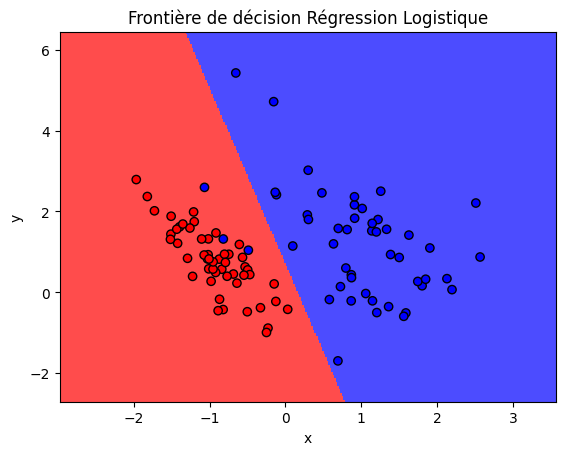

In [80]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("Taux d'erreur LDA : ",error_rate(y_test,y_pred_lda))
lda.decision_boundary(X, y)


logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print("Taux d'erreur Logistic Regression : ",error_rate(y_test,y_pred_log))
x = np.array([[0,0]])
print("Prédiction de la classe de x : ",logreg.predict(x.reshape(1,-1)))
logreg.decision_boundary(X, y)


Loss increasing at iteration 2230
Taux d'erreur Logistic Regression :  0.05


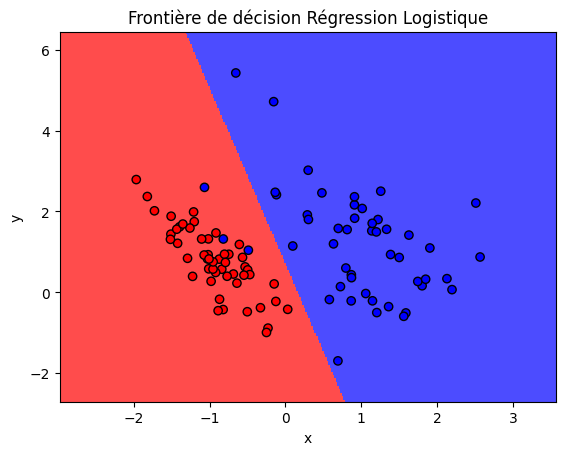

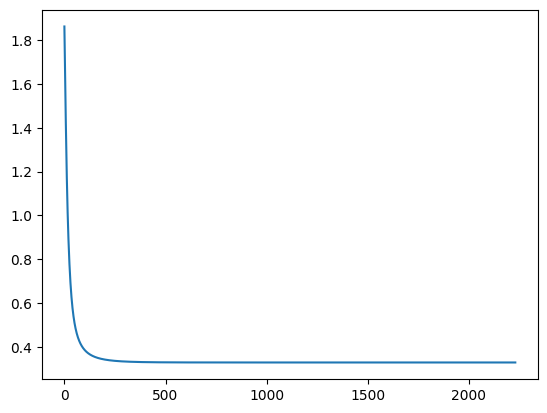

In [81]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print("Taux d'erreur Logistic Regression : ",error_rate(y_test,y_pred_log))
logreg.decision_boundary(X, y)
plt.plot(logreg.loss)

## II Méthodologie (5pts)

7. inclure une ligne permettant d'ajouter un outlier dans les données d'apprentissage (ligne commentée dans le bloc de génération de données).
Comparez les résultats de vos codes de régression logistique et de LDA sur ces données. Commenter (1pt)
8. en plus des taux d'erreurs en apprentissage et en test, appliquer une statégie de validation croisée à n blocs et reporter les taux d'erreur (moyenne et variance) des deux modèles. (2pts)
9. modifier le code de génération de données (en augmentant le nombre de dimensions et en ajoutant des variables correlées). Comparer le comportement des deux modèles (2pts)      *(on commentera à nouveau la ligne de génération d'outlier pour cette question)*



In [82]:
# Commentaire :
# La descente de gradient s'arrête plus tôt quand le gradient ne change plus significativement, et la frontière est plus ajustée sur le graphique.

## III A vous de jouer (7 pts)
10. Trouver/Générer/Récolter des données adéquates pour l'application d'un algorithme de classification binaire. Décrire ces données (origine, nombre et types de variables, analyse statistique des variables, nombre d'observations, contexte,...) (2pts)
11. Appliquer vos codes de régression logistique et de LDA et reporter les performances obtenues (en apprentissage, en test ou en validation croisées) et commenter (1pts)
12. Trouver une autre méthode à laquelle comparer les deux codes que vous avez développés, décrire (brièvement) le fonctionnement de cette troisème approche et l'appliquer sur les données (de la question 10). On pourra développer soit-même le code ou utiliser une librairie existante. Comparer et discuter les performances obtenues (4pts)